In [ ]:
!pip install scikeras
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


In [ ]:
!pip install keras-tuner
!pip install --upgrade keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.6 MB/s eta 0:00:00


In [ ]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.6 MB/s eta 0:00:00


Trial 67 Complete [00h 00m 12s]
val_accuracy: 0.7799999713897705

Best val_accuracy So Far: 0.8600000143051147
Total elapsed time: 00h 10m 31s

Best Hyperparameters:
- Neurons: 224
- Dropout Rate: 0.2
- Number of Layers: 1
- Learning Rate: 0.01

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.6518 - loss: 0.5658 - val_accuracy: 0.7600 - val_loss: 0.4939 - learning_rate: 0.0100
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8253 - loss: 0.3935 - val_accuracy: 0.8000 - val_loss: 0.4266 - learning_rate: 0.0100
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8325 - loss: 0.3811 - val_accuracy: 0.8000 - val_loss: 0.5293 - learning_rate: 0.0100
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8438 - loss: 0.3146 - val_accuracy: 0.8000 - val_loss: 0.5732 - learning_rate: 0.0100
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8556 - loss: 0.3229 - val_accuracy: 0.8400 - val_loss: 0.4654 - learning_rate: 0.0100
Epo

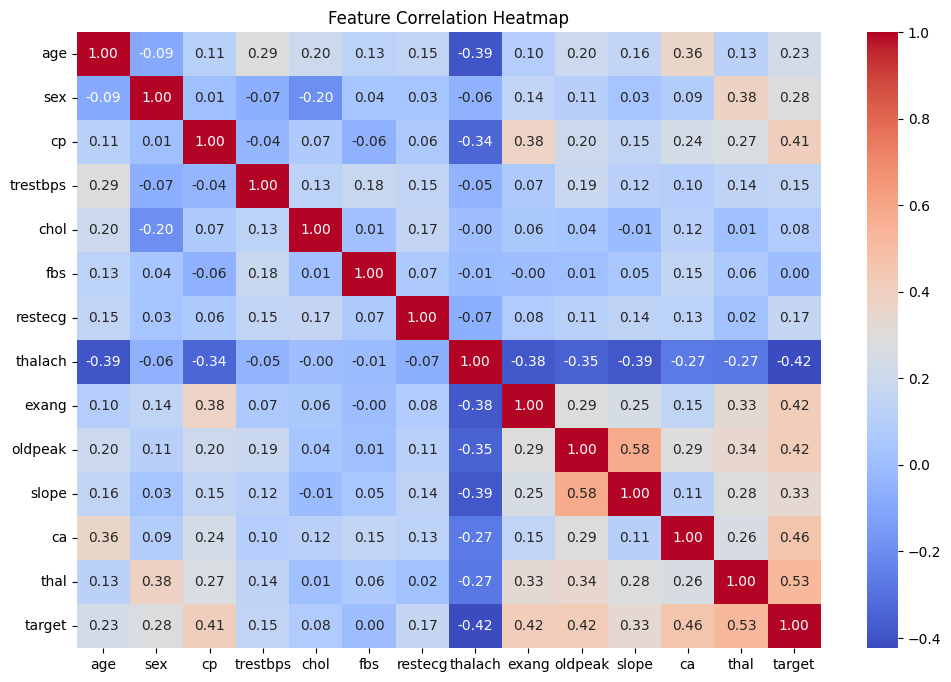

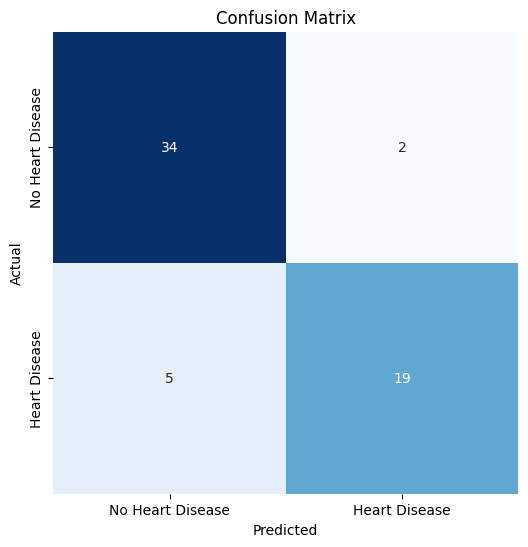

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


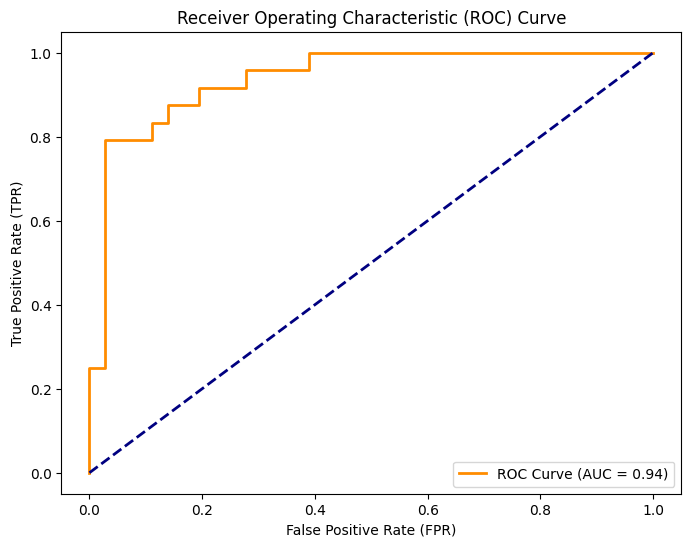

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


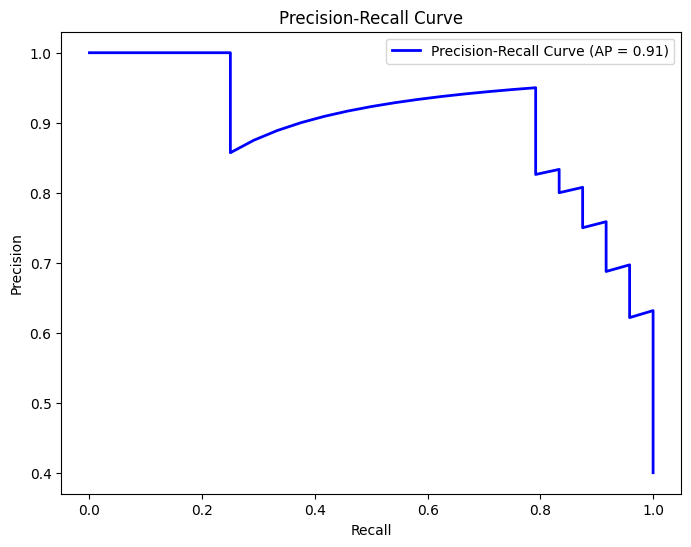

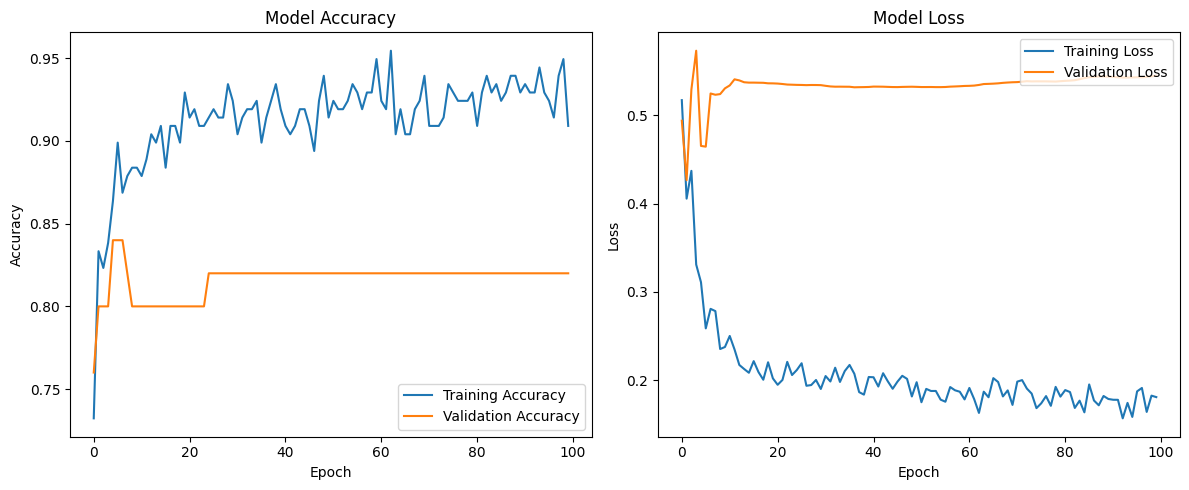

✅ Tabular Model saved successfully!
✅ Tabular Model loaded successfully!


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Import Keras Tuner
import keras_tuner as kt

# Load the UCI Heart Disease dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]
data = pd.read_csv(url, names=column_names, na_values="?")

# Handle missing values (if any)
data = data.dropna()

# Convert target to binary classification (0 = no heart disease, 1 = heart disease)
data["target"] = data["target"].apply(lambda x: 1 if x > 0 else 0)

# Split data into features (X) and target (y)
X = data.drop("target", axis=1)
y = data["target"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ==================================================
# Hyperparameter Tuning with Keras Tuner
# ==================================================

def build_model(hp):
    model = Sequential()

    # Tune the number of neurons in the first layer
    hp_neurons = hp.Int('neurons', min_value=32, max_value=256, step=32)
    model.add(Dense(hp_neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    # Tune the number of hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(hp.Int(f'neurons_{i}', min_value=32, max_value=128, step=32), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Custom callback to stop after N trials
class StopAfterNTrials(Callback):
    def __init__(self, max_trials):
        super().__init__()
        self.max_trials = max_trials
        self.trial_count = 0

    def on_epoch_end(self, epoch, logs=None):
        self.trial_count += 1
        if self.trial_count >= self.max_trials:
            self.model.stop_training = True  # Stop the search

# Initialize the Keras Tuner
tuner = kt.RandomSearch(  # Or Hyperband, but RandomSearch is easier for fixed trials
    build_model,
    objective='val_accuracy',
    max_trials=50,  # <-- THIS directly controls number of trials
    directory='keras_tuner',
    project_name='heart_disease'
)


# Perform hyperparameter search with the custom callback
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_split=0.2,
    verbose=1,
    callbacks=[StopAfterNTrials(max_trials=50)]  # Stop after 50 trials
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Neurons: {best_hps.get('neurons')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Number of Layers: {best_hps.get('num_layers')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[reduce_lr],
    verbose=1
)

# Evaluate the model
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# ==================================================
# Visualizations
# ==================================================

# 1. Heatmap for Data Correlation
plt.figure(figsize=(12, 8))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Heart Disease", "Heart Disease"],
            yticklabels=["No Heart Disease", "Heart Disease"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, best_model.predict(X_test))
average_precision = average_precision_score(y_test, best_model.predict(X_test))

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", lw=2, label=f"Precision-Recall Curve (AP = {average_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.show()

# 5. Training History Plot (Accuracy and Loss)
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

from tensorflow.keras.models import load_model

best_model.save('tabular_model.h5')
print("✅ Tabular Model saved successfully!")

tabular_model = load_model('tabular_model.h5')
print("✅ Tabular Model loaded successfully!")


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload the downloaded ECG dataset zip file


Saving gwbz3fsgp8-2.zip to gwbz3fsgp8-2.zip


In [ ]:
import zipfile

# Replace with your uploaded file name
with zipfile.ZipFile('/gwbz3fsgp8-2.zip', 'r') as zip_ref:
    zip_ref.extractall('ecg_images')


In [ ]:
import os

# List what is inside 'ecg_images' folder
print(os.listdir('ecg_images'))


['Normal Person ECG Images (284x12=3408)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)']


In [ ]:
import os
import shutil

base_dir = 'ecg_images'
binary_base_dir = 'binary_ecg_data'

# Create binary folders
os.makedirs(os.path.join(binary_base_dir, 'Normal'), exist_ok=True)
os.makedirs(os.path.join(binary_base_dir, 'Disease'), exist_ok=True)

# Normal folder name
normal_path = os.path.join(base_dir, 'Normal Person ECG Images (284x12=3408)')

# Move Normal ECGs
for filename in os.listdir(normal_path):
    shutil.copy(os.path.join(normal_path, filename), os.path.join(binary_base_dir, 'Normal'))

# Diseased folder names
disease_folders = [
    'ECG Images of Patient that have abnormal heartbeat (233x12=2796)',
    'ECG Images of Myocardial Infarction Patients (240x12=2880)',
    'ECG Images of Patient that have History of MI (172x12=2064)'
]

# Move Disease ECGs
for folder in disease_folders:
    folder_path = os.path.join(base_dir, folder)
    for filename in os.listdir(folder_path):
        shutil.copy(os.path.join(folder_path, filename), os.path.join(binary_base_dir, 'Disease'))

print("✅ Successfully organized Normal and Disease images!")


✅ Successfully organized Normal and Disease images!


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    'binary_ecg_data',  # new binary folder
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'binary_ecg_data',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


Found 744 images belonging to 2 classes.
Found 184 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification: Normal (0) or Disease (1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,  # You can increase later
    validation_data=validation_generator
)
# Save the trained CNN model
model.save('ecg_image_model.h5')
print("✅ ECG Image Model saved successfully!")

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 995ms/step - accuracy: 0.9075 - loss: 0.2276 - val_accuracy: 0.9348 - val_loss: 0.1872
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 878ms/step - accuracy: 0.9451 - loss: 0.1613 - val_accuracy: 0.9348 - val_loss: 0.1678
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 829ms/step - accuracy: 0.9554 - loss: 0.1211 - val_accuracy: 0.9348 - val_loss: 0.1725
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 900ms/step - accuracy: 0.9720 - loss: 0.1115 - val_accuracy: 0.9293 - val_loss: 0.1550
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9664 - loss: 0.0924 - val_accuracy: 0.9293 - val_loss: 0.1676
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 905ms/step - accuracy: 0.9765 - loss: 0.0805 - val_accuracy: 0.9511 - val_loss: 0.1169
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9780 - loss: 0.0586 - val_accuracy: 0.9348 - val_loss: 0.1881
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 847ms/step - accuracy: 0.9898 - loss: 0.0369 - val_accuracy: 

✅ ECG Image Model saved successfully!


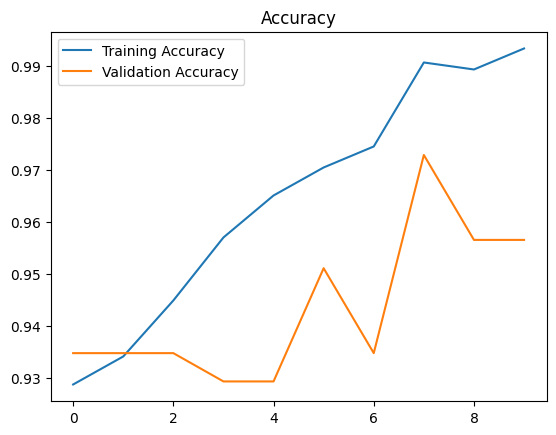

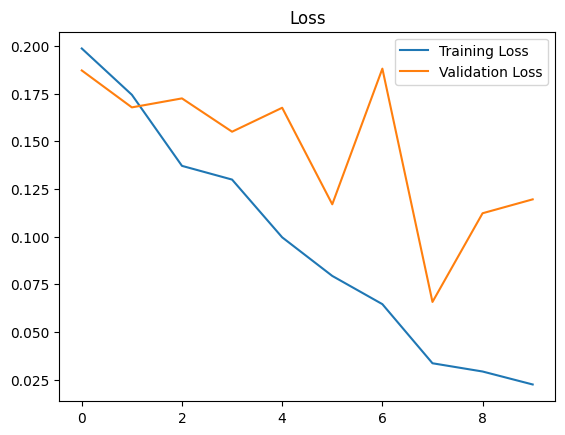

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [ ]:
# ================================
# Load Libraries
# ================================
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler
import joblib

# ================================
# Load Saved Models
# ================================
tabular_model = load_model('tabular_model.h5')
image_model = load_model('ecg_image_model.h5')

# ================================
# Load Scaler (if you saved it)
# ================================
# If you didn't save it separately earlier, skip this line
# scaler = joblib.load('scaler.pkl')

# Otherwise, if using the same session where you fitted scaler:
# scaler = your previously fitted scaler

# ================================
# Prediction Function
# ================================
def predict_combined(tabular_features, img_path, scaler):
    """
    tabular_features: numpy array of shape (1, 13) - features for tabular model
    img_path: string - path to the ECG image
    scaler: StandardScaler used during training

    Returns:
        final_class: int (0 = Normal, 1 = Disease)
    """

    # Scale tabular input
    tabular_features_scaled = scaler.transform(tabular_features)

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Get predictions
    tabular_pred = tabular_model.predict(tabular_features_scaled)[0][0]
    image_pred = image_model.predict(img_array)[0][0]

    # Combine predictions (simple average)
    final_pred_prob = (tabular_pred + image_pred) / 2.0

    # Final classification
    final_class = 1 if final_pred_prob > 0.5 else 0

    return final_class, final_pred_prob

# ================================
# Example Usage
# ================================
# Example tabular input (replace with your real data)
tabular_input = np.array([[63, 1, 3, 145, 233, 1, 0, 150, 0, 2.3, 0, 0, 1]])

# Example image path (replace with your real path)
img_path = '/content/ecg_images/Normal Person ECG Images (284x12=3408)/Normal(1).jpg'

# Predict
final_class, final_pred_prob = predict_combined(tabular_input, img_path, scaler)

# Output
if final_class == 1:
    print(f"🫀 Disease Detected! (Probability: {final_pred_prob:.2f})")
else:
    print(f"💓 Normal Heart! (Probability: {final_pred_prob:.2f})")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
💓 Normal Heart! (Probability: 0.41)
